# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

**Цель**: получить модель для определения стоимости автомобиля на основании технических характеристик, комплектации и цены автомобилей.

**Задачи**:
- загрузить и подготовить данные;
- обучить разные модели и к каждой подобрать гиперпараметры;
- проанализировать скорость работы, время обучения и качество модели.

<div class="alert alert-block alert-warning">
<b>Совет:</b> Важно чтобы в проектах было подробное описание: когда потенциальные работодатели будут смотреть твой проект в портфолио, им нужно будет понимать задачу, чтобы можно было оценить её решение. Вот что можно добавить:
    
* Описание целей и задачи проекта
* Описание данных
* План работы
</div>

## Подготовка данных

### Импорт библиотек и загрузка данных

Для начала сделаем импорт всех необходимых библиотек:

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import numpy as np
import warnings
import re
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor
import lightgbm as lgb

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

Загрузим файл и прочитаем из него несколько строк для наглядности.

In [2]:
try:
    df = pd.read_csv(r'C:\Users\valentina.tikhova\Downloads\autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

display(df.sample(3))
df.shape

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
314040,2016-03-08 11:49:37,10500,sedan,2009,manual,300,leon,150000,4,petrol,seat,no,2016-03-08 00:00:00,0,31157,2016-04-07 10:46:20
81214,2016-03-16 18:41:33,1200,sedan,1995,manual,75,corolla,150000,8,petrol,toyota,no,2016-03-16 00:00:00,0,88131,2016-03-17 16:47:48
42172,2016-03-30 14:58:50,5590,small,2009,manual,69,500,50000,5,petrol,fiat,no,2016-03-30 00:00:00,0,93055,2016-04-07 06:15:47


(354369, 16)

У нас в распоряжении порядка 350k записей о машинах в разрезе:
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя


### EDA

Сходу уберем дубли и посмотрим информацию о данных: описательную статистику, типы данных и пропуски в них.

In [3]:
df = df.drop_duplicates()

In [4]:
def df_info(df):
    ''' Func show describe, dtypes and missing_values
    '''
    return pd.concat([df.describe(include = 'all').round(2).fillna('-').T, 
           df.dtypes,
           round(np.mean(df.isnull())*100)], axis=1).rename(columns={0:'dtypes', 1:'missing_%'})

In [5]:
df_info(df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_%
DateCrawled,354365,271174,2016-03-24 14:49:47,7,-,-,-,-,-,-,-,object,0.0
Price,354365.0,-,-,-,4416.68,4514.18,0.0,1050.0,2700.0,6400.0,20000.0,int64,0.0
VehicleType,316875,8,sedan,91457,-,-,-,-,-,-,-,object,11.0
RegistrationYear,354365.0,-,-,-,2004.23,90.23,1000.0,1999.0,2003.0,2008.0,9999.0,int64,0.0
Gearbox,334532,2,manual,268249,-,-,-,-,-,-,-,object,6.0
Power,354365.0,-,-,-,110.09,189.85,0.0,69.0,105.0,143.0,20000.0,int64,0.0
Model,334660,250,golf,29232,-,-,-,-,-,-,-,object,6.0
Kilometer,354365.0,-,-,-,128211.36,37905.08,5000.0,125000.0,150000.0,150000.0,150000.0,int64,0.0
RegistrationMonth,354365.0,-,-,-,5.71,3.73,0.0,3.0,6.0,9.0,12.0,int64,0.0
FuelType,321470,7,petrol,216349,-,-,-,-,-,-,-,object,9.0


Видим пропуски в данных по типу кузова (11%) и коробки передач (6%), модели автомобиля (6%), типу топлива (9%), а так же не указано, была ли машина в ремонте (20%). 

Можно предположить, что такие характеристики как тип кузова, коробка передач и тип топлива будут схлжи в одинаковых моделях автомобиля. Поэтому пропущенные данных по ним можно заполнить:

In [6]:
for col in ['VehicleType', 'Gearbox', 'FuelType']:
    f = lambda x: x.value_counts().idxmax()
    df[col] = df.groupby('Model', dropna=False)[col].transform(f)

Узнать, была ли машина в ремонте, не сможем никак, поэтому просто заполним флагом:

In [7]:
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

Модель автомобиля тоже никак не угадать, удалим такие записи:

In [8]:
df = df.loc[~df['Model'].isna()]

Сконвертируем типы данных на нужные (отдельно зададим формат дат).

In [9]:
df = df.convert_dtypes()

In [10]:
for col in ['DateCrawled', 'LastSeen']:
    df[col] =  pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

Признаки почтового индекса и наличии картинки не влияет ни на что, от них можно избавиться. Дата скачивания анкеты и дата создания актеты почти идентичны, оставим только первую. Месяц регистрации не несет полезной информации, можно его удалить.

In [11]:
df.drop(['DateCreated', 'PostalCode', 'NumberOfPictures', 'RegistrationMonth'], axis=1, inplace=True)

Единственная значимая характеристика автомобиля, которая имеет влияние (обратное) на цену, - это пробег.

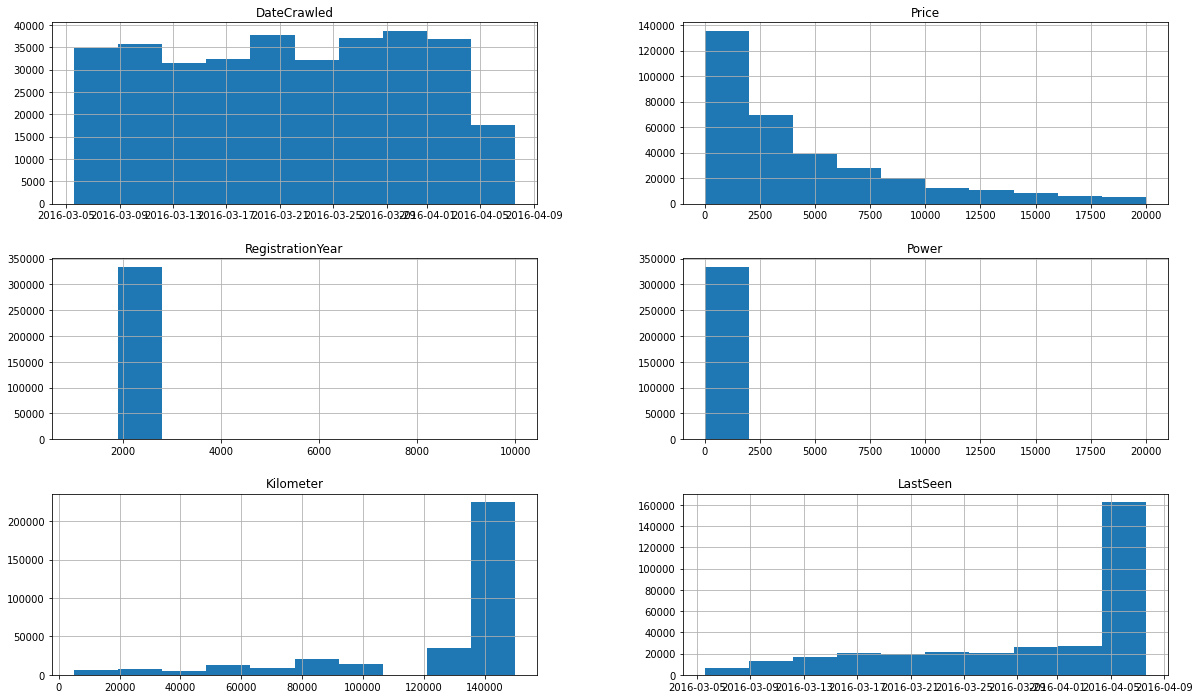

In [12]:
df.hist(figsize=(20,12));

Посмотрим выбросы в данных и сразу же избавляемся от них:

In [13]:
for col in df.select_dtypes(include=[np.number]).columns:
    lower = df[col].quantile(q=0.025)
    upper = df[col].quantile(q=0.975)
    df = df[(df[col] > lower) & (df[col] < upper)]   
    print(f'{col:}: {lower = } and {upper = }')

Price: lower = 0.0 and upper = 16900.0
RegistrationYear: lower = 1990.0 and upper = 2017.0
Power: lower = 0.0 and upper = 233.0
Kilometer: lower = 30000.0 and upper = 150000.0


Для дальнейшего обучения надо привести категориальные переменные в количественные, а также их стандартизировать. А исходный df сохраним в df_cat.

In [14]:
df_cat = df.copy()

In [15]:
cat_col = df.select_dtypes(exclude=[np.number]).columns
label_encode = LabelEncoder()

for col in cat_col:
    label_encode.fit(df[col].astype('str'))
    df[col] = label_encode.transform(df[col].astype('str'))

In [16]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,LastSeen
2,19993,9800,5,2004,0,163,112,125000,0,14,1,37631
4,59879,3600,4,2008,1,69,98,90000,1,31,0,44625
20,62793,10400,2,2009,1,160,189,100000,1,37,0,38915
27,3868,6900,3,2008,1,99,70,60000,1,11,0,20342
36,13264,1600,3,1991,1,75,123,70000,1,24,1,50414


In [17]:
scaler = StandardScaler()
numeric = ['DateCrawled', 'VehicleType', 'RegistrationYear', 'Gearbox','Power', 'Model', 'Kilometer', 
           'FuelType', 'Brand', 'NotRepaired','LastSeen']
scaler.fit(df[numeric])
df[numeric] = scaler.transform(df[numeric])

Посмотрим, как зависят признакми друг от друга.

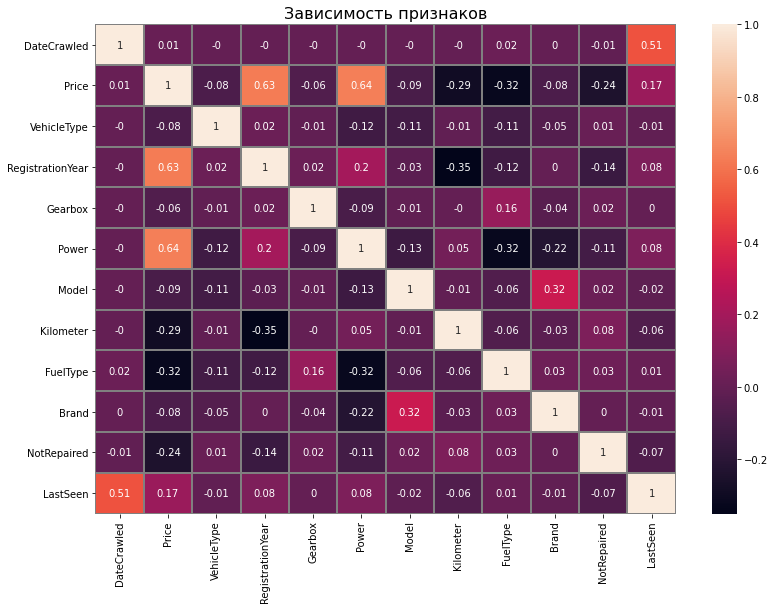

In [18]:
plt.figure(figsize=(13,9))
plt.title('Зависимость признаков', fontsize=16)
sns.heatmap(df.corr().round(2), annot=True, linewidths=1,  linecolor='gray');

В итоге:
* избавились от выбросов в данных
* убрали пропущенные значения
* больше нет дубликатов в данных
* справили типы данных
* от признаков, которые не несут полезную информацию, избавились
* заметили обратную зависимость цены от пробега машины и типа топлива и прямую зависимость от мощности и года регистрации.

## Обучение моделей

Традиционно выделим признаки и цель, а также разделим выборку на обучающую и тестовую. А еще закрепим констанкту random_state.

In [19]:
RANDOM_STATE = 1234

In [20]:
def prepare_model(df):

    X = df.drop('Price', axis=1)
    y = df['Price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    
    return X_train, X_test, y_train, y_test

Начнем строить модели и посчитаем время:
* её обучения;
* её предсказания;
* расчета метрики RMSE.

Обернем все стадии постоения и оценки модели в функцию -- так проще будет проводить последующий анализ.

**Сразу отмечу, что использовала GridSearchCV для нахождения лучших параметров модели. Так как в тренажере результат выполнения не дождаться, выполнила подбор на локальной машине, и применила их в своей работе.**

In [21]:
def time_model(model, df):

    X_train, X_test, y_train, y_test = prepare_model(df)

    time_col = ['model_fit', 'predict', 'rmse']
    time_val = []

    start_fit = time.time()
    model = model
    model.fit(X_train, y_train.astype('int32'))
    end_fit = time.time()

    time_val.append(end_fit-start_fit)

    start_pred = time.time()
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    end_pred = time.time()

    time_val.append(end_pred-start_pred)

    start_rmse = time.time()
    rmse_train = mean_squared_error(y_train, pred_train) ** 0.5
    rmse_test = mean_squared_error(y_test, pred_test) ** 0.5
    end_rmse = time.time()
    time_val.append(end_rmse-start_rmse)
    rmse = f'{rmse_train = }, {rmse_test = }'

    time_df = pd.DataFrame(list(zip(time_col, time_val)), columns = ['time', 'sec'])
    rmse_df = pd.DataFrame(list(zip(['rmse_train', 'rmse_test'], [rmse_train, rmse_test])), columns = ['rmse', 'value'])

    return time_df.round(3), rmse_df.round(3)

#### Линейная регрессия

In [22]:
%%time
time_LR, rmse_LR = time_model(LinearRegression(), df)

CPU times: user 162 ms, sys: 110 ms, total: 272 ms
Wall time: 252 ms


#### Дерево решений

In [23]:
%%time
time_DT, rmse_DT = time_model(DecisionTreeRegressor(min_samples_split = 2, min_samples_leaf = 12, max_depth = 18), df)

CPU times: user 334 ms, sys: 0 ns, total: 334 ms
Wall time: 340 ms


#### Случайный лес

In [24]:
%%time
time_RF, rmse_RF = time_model(RandomForestRegressor(n_estimators = 40, min_samples_split = 2, max_depth = 15), df)

CPU times: user 8.63 s, sys: 28.1 ms, total: 8.66 s
Wall time: 8.67 s


### LightGBM

Модель умеет работать с категориальными переменными, поэтому берем в работу df. Заодно переберем несколько гиперпараметров:
* n_estimators - количество деревьев;
* num_leaves - количество листьев дерева

Сделаем подбор параметров и их перебор через GridSearchCV.

In [25]:
%%time
time_LGBM, rmse_LGBM = time_model(lgb.LGBMRegressor(n_estimators = 160, num_leaves = 18), df)

CPU times: user 6min 27s, sys: 4.36 s, total: 6min 31s
Wall time: 6min 33s


### CatBoost

Так как модель умеет работать с категориальными признаками. воспользуемся датасетом df_cat, оставив в нем только категориальные признаки.

In [26]:
cat_col = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'NotRepaired']

df_cat = df_cat.drop(['DateCrawled', 'LastSeen'], axis=1)

df_cat[cat_col] = df_cat[cat_col].astype('category')

In [27]:
%%time
time_CB, rmse_CB = time_model(CatBoostRegressor(loss_function = 'RMSE', cat_features = cat_col), df_cat)

Learning rate set to 0.078558
0:	learn: 4124.3452597	total: 119ms	remaining: 1m 58s
1:	learn: 3901.5215436	total: 158ms	remaining: 1m 18s
2:	learn: 3695.3211934	total: 203ms	remaining: 1m 7s
3:	learn: 3510.0072049	total: 238ms	remaining: 59.3s
4:	learn: 3345.7088410	total: 300ms	remaining: 59.7s
5:	learn: 3191.3388215	total: 355ms	remaining: 58.8s
6:	learn: 3058.6418856	total: 409ms	remaining: 58s
7:	learn: 2933.7300105	total: 469ms	remaining: 58.1s
8:	learn: 2824.1144718	total: 513ms	remaining: 56.5s
9:	learn: 2719.6820702	total: 568ms	remaining: 56.3s
10:	learn: 2623.4914760	total: 613ms	remaining: 55.1s
11:	learn: 2541.7030840	total: 655ms	remaining: 53.9s
12:	learn: 2467.7484665	total: 710ms	remaining: 53.9s
13:	learn: 2396.7741301	total: 756ms	remaining: 53.2s
14:	learn: 2337.1317198	total: 802ms	remaining: 52.7s
15:	learn: 2281.9270389	total: 837ms	remaining: 51.5s
16:	learn: 2235.6274765	total: 882ms	remaining: 51s
17:	learn: 2192.4201065	total: 917ms	remaining: 50.1s
18:	learn:

## Анализ моделей

Итого, посмотрим на "замеры" обычных моделей и моделей градиентного спуска, для этого напишем функцию отрисовки графика `check_models`:

In [28]:
def check_models(time, names, *dfs):
    simple_models = pd.concat(dfs, keys = names, axis=0).reset_index()
    
    f, ax = plt.subplots(figsize=(15, 5))
    
    if time:
        X = "sec"
        HUE = "time"
        TITLE = 'Распределение скорости расчета, сек'

        
    else:
        X = "value"
        HUE = "rmse"        
        TITLE = 'Распределение показателя RMSE'
    
    sns.barplot(y = "level_0", x = X, data=simple_models, hue = HUE)
    
    [ax.text(i.get_width(), i.get_y()+0.15, str(i.get_width()), fontsize=10) for i in ax.patches]
    
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.4)   
    
    ax.set_title(TITLE, loc='left', pad=10, fontweight="bold")    
    
    ax.legend(ncol=3, loc="lower right", frameon=True)  
    
    ax.set_ylabel('model')
    ax.set_xlabel(HUE)
    
    sns.despine(left=True, bottom=True)

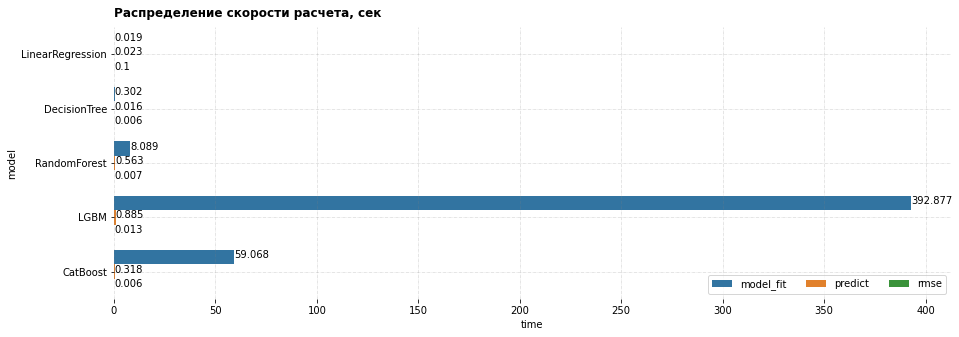

In [29]:
check_models(True, 
             ('LinearRegression', 'DecisionTree', 'RandomForest', 'LGBM', 'CatBoost'), 
             time_LR, time_DT, time_RF, time_LGBM, time_CB)

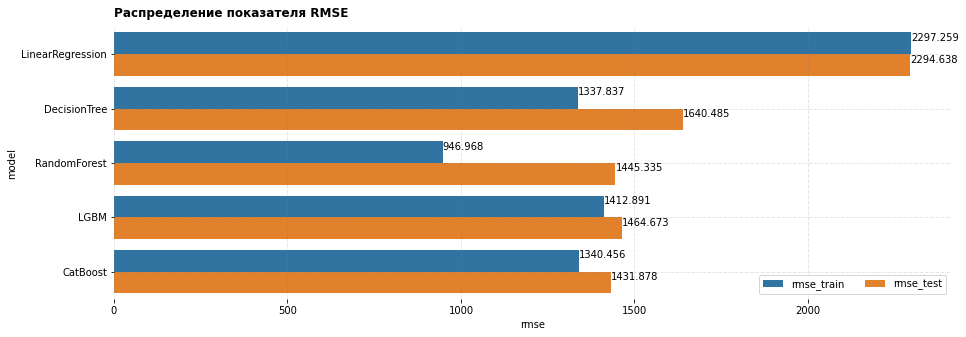

In [30]:
check_models(False, 
             ('LinearRegression', 'DecisionTree', 'RandomForest', 'LGBM', 'CatBoost'), 
             rmse_LR, rmse_DT, rmse_RF, rmse_LGBM, rmse_CB)

**ИТОГО, как видно из полученных результатов:**
* самой долгой по обучаемости становится модель LGBM, которой надо порядка 7 минут, около минуты длится обучение и CatBoost. Самая быстрая модель по обучаемости ожидаемо Линейная регрессия
* предстазывают модели оперативно, результаты замеров почти не отличатся
* по качеству выигрывает модель LGBM с минимальным отрывом от CatBoost.